## XGBoost

The goal of this notebook is to test the XGBoost model on the BANES dataset, merged with the weather data.

Different planned models (all of them w/ the weather data):

- XGBoost with the weather data
- day of week as a feature, hour and day of year.
- is_weekend as a feature, hour and day of year.
- Use the last 24 hours
- Use the last 5-10 days of data at the same time.

In order to repeat the data the least, we will pre-process the 3 dataframes, before we use the XGBoost model.


In [1]:
# import tqdm - progress bar
from tqdm import tqdm

# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import xgboost
import xgboost as xgb

# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

pd.options.mode.chained_assignment = None  # default='warn'


In [7]:
df = pd.read_csv('BANES_weather_merged.csv', parse_dates=['time'])
# remove duplicates
df = df.groupby(['time', 'location', 'postcode']).mean().reset_index()
df.head()


,time,location,postcode,energy,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco
0,2006-10-01 00:30:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.8,14.95,13.80,93.0,0.0,0.0,175.0,13.9,NaN,1001.8,NaN
1,2006-10-01 01:00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,33.0,14.80,13.50,92.0,0.0,0.0,180.0,14.8,NaN,1001.7,NaN
2,2006-10-01 01:30:00,Bath Central Library Electricity (HH),BA1 5AL,5.9,14.75,13.35,91.5,0.0,0.0,180.0,13.9,NaN,1001.7,NaN
3,2006-10-01 01:30:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.7,14.75,13.35,91.5,0.0,0.0,180.0,13.9,NaN,1001.7,NaN
4,2006-10-01 02:00:00,Guildhall Electricity Supply 1 (HH),BA1 5AW,32.2,14.70,13.20,91.0,0.0,0.0,180.0,13.0,NaN,1001.7,NaN


##### Help functions

Help functions for pre-processing, building, and plotting the model.

In [2]:
def pre_processing(df: pd.DataFrame, X_columns, y_columns, random=True, test_size=0.2):
    """ Pre-processing function

    This function takes a dataframe and splits it into X and y. 
    It also splits the data into train and test.

    Args:
        df: pandas dataframe
        X_columns: list of columns to be used as X
        y_columns: list of columns to be used as y
        random: boolean, if True, randomize the dataframe
        test_size: float, the size of the test set

    Returns:
        X_train: numpy array of X_train
        X_test: numpy array of X_test
        y_train: numpy array of y_train
        y_test: numpy array of y_test
    """
    X = df[X_columns]
    y = df[y_columns]

    if random:
        # split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42)
    else:
        # get first train size of data as train
        X_train = X.iloc[:int(X.shape[0] * (1 - test_size))]
        y_train = y.iloc[:int(y.shape[0] * (1 - test_size))]
        # get remaining data as test
        X_test = X.iloc[int(X.shape[0] * (1 - test_size)):]
        y_test = y.iloc[int(y.shape[0] * (1 - test_size)):]

    return X_train, X_test, y_train, y_test


def build_model(X_train: np.array, y_train: np.array, X_test: np.array):
    """
    This function builds a model.

    Args:
        X_train: numpy array of X_train
        y_train: numpy array of y_train
        X_test: numpy array of X_test

    Returns:
        model: xgboost model
        preds: numpy array of predictions
    """
    # # set parameters
    # params = {
    #     'max_depth': 5,
    #     'eta': 0.1,
    #     'objective': 'reg:squarederror',
    #     'eval_metric': 'rmse',
    #     'verbosity': 1,
    #     'seed': 42
    # }

    # # train model
    # model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)

    # # make predictions
    # preds = model.predict(xgb.DMatrix(X_test))

    model = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, verbosity=1, seed=42)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    return model, preds


def plot_results(preds: np.array, actuals: np.array, title: str):
    """ Plotting function

    This function plots the predicted and actual values.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()


def performance_metrics(preds: np.array, actuals: np.array):
    """ Performance metrics function

    This function calculates the performance metrics.

    Args:
        preds: numpy array of predicted values
        actuals: numpy array of actual values
    """
    # calculate performance metrics
    mse = mean_squared_error(actuals, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, preds)
    wmape = np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    print('MSE: %.4f' % mse)
    print('RMSE: %.4f' % rmse)
    print('MAE: %.4f' % mae)
    print('WMAPE: %.4f' % wmape)
    print('R2: %.4f' % r2)
    

### First Model

Predict using only the weather data, i.e., the humidity, temperature, wind speed, and pressure.

In [9]:
df1 = df[['energy', 'temp', 'rhum', 'wspd', 'pres']]
df1.head()


,energy,temp,rhum,wspd,pres
0,32.8,14.95,93.0,13.9,1001.8
1,33.0,14.80,92.0,14.8,1001.7
2,5.9,14.75,91.5,13.9,1001.7
3,32.7,14.75,91.5,13.9,1001.7
4,32.2,14.70,91.0,13.0,1001.7


##### Second Model

Day of week as a feature, hour and day of year.

In [10]:
df2 = df[['energy', 'temp', 'rhum', 'wspd', 'pres', 'time']]
df2.loc[:, 'dayofweek'] = df2['time'].dt.dayofweek
df2.loc[:, 'hour'] = df2['time'].dt.hour
df2.loc[:, 'dayofyear'] = df2['time'].dt.dayofyear
df2.drop(['time'], axis=1, inplace=True)
df2.head()


,energy,temp,rhum,wspd,pres,dayofweek,hour,dayofyear
0,32.8,14.95,93.0,13.9,1001.8,6,0,274
1,33.0,14.80,92.0,14.8,1001.7,6,1,274
2,5.9,14.75,91.5,13.9,1001.7,6,1,274
3,32.7,14.75,91.5,13.9,1001.7,6,1,274
4,32.2,14.70,91.0,13.0,1001.7,6,2,274


##### Third Model

Is weekend as a feature, hour and day of year.

In [11]:
df3 = df[['energy', 'time', 'temp', 'rhum', 'wspd', 'pres']]
df3.loc[:, 'is_weekend'] = df3['time'].dt.dayofweek.isin([5, 6])
df3.loc[:, 'hour'] = df3['time'].dt.hour
df3.loc[:, 'dayofyear'] = df3['time'].dt.dayofyear
df3.drop(['time'], axis=1, inplace=True)
df3.head()


,energy,temp,rhum,wspd,pres,is_weekend,hour,dayofyear
0,32.8,14.95,93.0,13.9,1001.8,True,0,274
1,33.0,14.80,92.0,14.8,1001.7,True,1,274
2,5.9,14.75,91.5,13.9,1001.7,True,1,274
3,32.7,14.75,91.5,13.9,1001.7,True,1,274
4,32.2,14.70,91.0,13.0,1001.7,True,2,274


##### Fourth Model

Use the last 24 hours data.

In [12]:
df4 = df[['energy', 'temp', 'rhum', 'wspd', 'pres', 'time', 'location']]

df4 = df4.groupby(['time', 'location']).mean().reset_index().sort_values(['location', 'time'])

# the data is half hourly, so we need the last 48 rows
for i in range(1, 49):
    df4[f'energy_{i}'] = df4.shift(i)['energy']

df4.head()


,time,location,energy,temp,rhum,wspd,pres,energy_1,energy_2,energy_3,...,energy_39,energy_40,energy_41,energy_42,energy_43,energy_44,energy_45,energy_46,energy_47,energy_48
78311,2008-06-14 00:30:00,## OLD Paulton Library Electricity Supply 1,0.08,9.6,81.0,11.2,1017.75,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78321,2008-06-14 01:00:00,## OLD Paulton Library Electricity Supply 1,0.07,9.6,81.0,9.4,1017.60,0.08,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78346,2008-06-14 02:30:00,## OLD Paulton Library Electricity Supply 1,0.08,9.1,81.0,7.6,1017.45,0.07,0.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78355,2008-06-14 03:00:00,## OLD Paulton Library Electricity Supply 1,0.07,8.6,81.0,7.6,1017.40,0.08,0.07,0.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78374,2008-06-14 04:00:00,## OLD Paulton Library Electricity Supply 1,0.07,8.6,81.0,5.4,1016.90,0.07,0.08,0.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df4_copy = df4.copy()

# for the first 48 values of each location, drop the first rows
# they don't have the correct values
# since they are either NaN or of other locations

locations = df4['location'].unique()
rows_to_delete = []

for location in locations:
    rows_to_delete.append(df4[df4['location'] == location].index[:48])

rows_to_delete = [i for index in rows_to_delete for i in index]
# drop rows, rows_to_delete contains their index
df4_copy.drop(rows_to_delete, inplace=True)


In [14]:
df4 = df4_copy

df4.drop(['time', 'location'], axis=1, inplace=True)
df4.head()


,energy,temp,rhum,wspd,pres,energy_1,energy_2,energy_3,energy_4,energy_5,...,energy_39,energy_40,energy_41,energy_42,energy_43,energy_44,energy_45,energy_46,energy_47,energy_48
78994,0.08,16.6,57.5,11.2,1010.70,0.08,0.08,0.08,0.08,0.08,...,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08,0.07,0.08
79002,0.08,17.6,52.0,11.2,1010.60,0.08,0.08,0.08,0.08,0.08,...,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08,0.07
79011,0.08,16.6,59.5,13.0,1010.45,0.08,0.08,0.08,0.08,0.08,...,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08
79028,0.08,15.6,65.0,12.1,1010.25,0.08,0.08,0.08,0.08,0.08,...,0.56,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07
79037,0.08,15.6,63.0,9.4,1010.20,0.08,0.08,0.08,0.08,0.08,...,0.91,0.56,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07


##### Fifth Model

Use the last 5-10 days of data from the same time.

In [15]:
df5 = df[['energy', 'temp', 'rhum', 'wspd', 'pres', 'time', 'location']]

df5 = df5.groupby(['time', 'location']).mean().reset_index().sort_values(['location', 'time'])

for i in range(1, 11):
    # shift 10 days
    df5[f'energy_{i}'] = df5.shift(i * 48)['energy']

df5.head()


,time,location,energy,temp,rhum,wspd,pres,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,energy_10
78311,2008-06-14 00:30:00,## OLD Paulton Library Electricity Supply 1,0.08,9.6,81.0,11.2,1017.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78321,2008-06-14 01:00:00,## OLD Paulton Library Electricity Supply 1,0.07,9.6,81.0,9.4,1017.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78346,2008-06-14 02:30:00,## OLD Paulton Library Electricity Supply 1,0.08,9.1,81.0,7.6,1017.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78355,2008-06-14 03:00:00,## OLD Paulton Library Electricity Supply 1,0.07,8.6,81.0,7.6,1017.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78374,2008-06-14 04:00:00,## OLD Paulton Library Electricity Supply 1,0.07,8.6,81.0,5.4,1016.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
locations = df5['location'].unique()
rows_to_delete = []

for i in tqdm(range(len(locations))):
    location = locations[i]
    # get the first 10 days of each location
    rows_to_delete.append(df5[df5['location'] == location].index[:10 * 48])

rows_to_delete = [i for index in rows_to_delete for i in index]


100%|██████████| 72/72 [01:01<00:00,  1.17it/s]


In [17]:
# drop rows, rows_to_delete contains their index
df5.drop(rows_to_delete, inplace=True)

df5.drop(['time', 'location'], axis=1, inplace=True)
df5.head()


,energy,temp,rhum,wspd,pres,energy_1,energy_2,energy_3,energy_4,energy_5,energy_6,energy_7,energy_8,energy_9,energy_10
84869,0.08,15.1,79.5,36.9,1017.30,0.07,0.08,0.08,0.08,0.08,0.08,0.08,0.07,0.08,0.08
84886,0.08,14.6,82.0,29.5,1017.70,0.08,0.07,0.07,0.08,0.08,0.07,0.08,0.08,0.08,0.07
84893,0.07,14.6,82.0,27.7,1017.90,0.08,0.08,0.08,0.08,0.08,0.07,0.08,0.08,0.08,0.08
84902,0.08,14.1,85.0,25.0,1018.25,0.07,0.09,0.08,0.08,0.07,0.23,0.08,0.07,0.08,0.07
84912,0.08,13.6,88.0,22.3,1018.60,0.08,0.08,0.07,0.07,0.08,0.60,0.08,0.08,0.08,0.07


In [18]:
# save the files to pickle
df1.to_pickle('df1.pkl')
df2.to_pickle('df2.pkl')
df3.to_pickle('df3.pkl')
df4.to_pickle('df4.pkl')
df5.to_pickle('df5.pkl')


## Build the models

In this section, we will create and train the XGBoost models.


#### First Model

In [19]:
# load the files from pickle
df1: pd.DataFrame = pd.read_pickle('df1.pkl')

y_cols = ['energy']
X_cols = ['temp', 'rhum', 'wspd', 'pres']

X_train, X_test, y_train, y_test = pre_processing(df1, X_cols, y_cols, test_size=0.2)


In [20]:
_, preds = build_model(X_train, y_train, X_test)


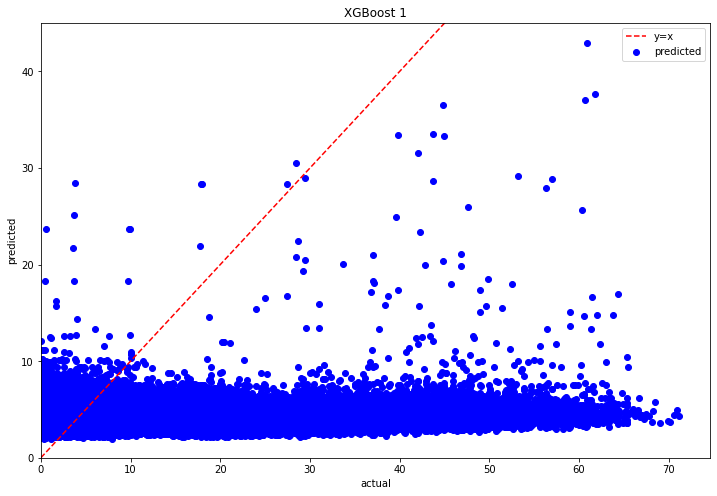

In [21]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 1')


In [30]:
performance_metrics(preds, y_test.values.reshape(-1))

MSE: 72.0691
RMSE: 8.4894
MAE: 5.0448
WMAPE: 124.2686
R2: 0.0085


### Second Model

In [31]:
# load the files from pickle
df2: pd.DataFrame = pd.read_pickle('df2.pkl')

# X_cols is all the columns except the energy
X_cols = df2.columns.difference(['energy'])
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df2, X_cols, y_cols)


In [32]:
_, preds = build_model(X_train, y_train, X_test)


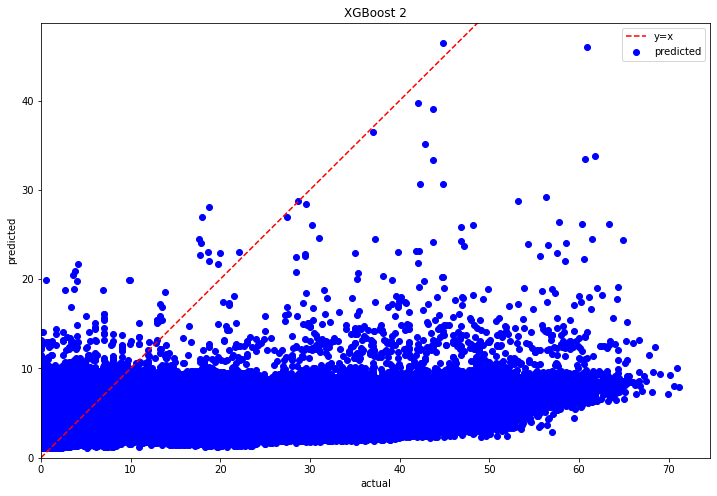

In [33]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 2')


In [34]:
performance_metrics(preds, y_test.values.reshape(-1))

MSE: 68.8945
RMSE: 8.3003
MAE: 4.8768
WMAPE: 120.1312
R2: 0.0522


### Third Model

In [35]:
# load the files from pickle
df3: pd.DataFrame = pd.read_pickle('df3.pkl')

# X_cols is all the columns except the energy
X_cols = df3.columns.difference(['energy'])
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df3, X_cols, y_cols, random=True)


In [36]:
# build the model
_, preds = build_model(X_train, y_train, X_test)


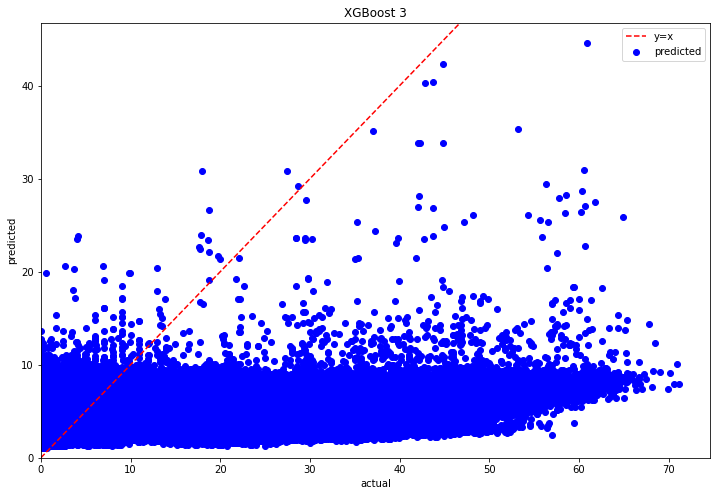

In [37]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 3')


In [38]:
performance_metrics(preds, y_test.values.reshape(-1))


MSE: 69.0163
RMSE: 8.3076
MAE: 4.8811
WMAPE: 120.2364
R2: 0.0505


### Fourth Model

In [4]:
# load the files from pickle
df4: pd.DataFrame = pd.read_pickle('df4.pkl')

X_cols = df4.columns.difference(['energy'])
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df4, X_cols, y_cols)


In [40]:
_, preds = build_model(X_train, y_train, X_test)


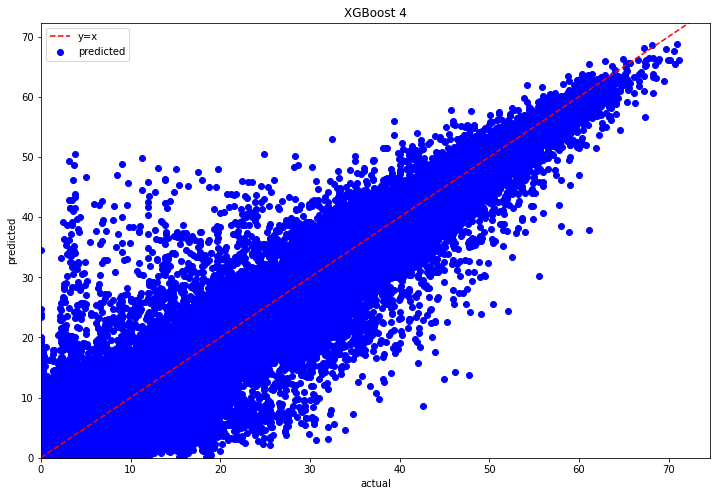

In [41]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 4')


In [42]:
performance_metrics(preds, y_test.values.reshape(-1))


MSE: 1.7758
RMSE: 1.3326
MAE: 0.5052
WMAPE: 12.4162
R2: 0.9757


XGBosst 5 hours


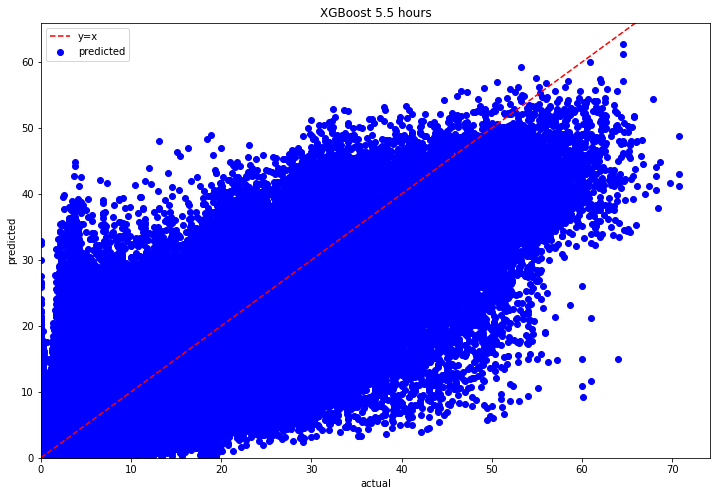

MSE: 12.9097
RMSE: 3.5930
MAE: 1.7078
WMAPE: 41.8097
R2: 0.8244


In [7]:
# load the files from pickle
print(f'XGBoost 5 hours')

X_cols = df4.columns.difference(['energy', *[f'energy_{j}' for j in range(11, 49)]])
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df4, X_cols, y_cols)

_, preds = build_model(X_train, y_train, X_test)

plt.figure(figsize=(12, 8))

plot_results(preds, y_test, f'XGBoost 5 hours')

performance_metrics(preds, y_test.values.reshape(-1))
    

In [6]:
X_cols = df4.columns.difference(['energy', 'energy_1'])
y_cols = ['energy', 'energy_1']

X_train, X_test, y_train, y_test = pre_processing(df4, X_cols, y_cols)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4021213, 51), (1005304, 51), (4021213, 2), (1005304, 2))

In [9]:
from sklearn.multioutput import MultiOutputRegressor

multi_output_model = MultiOutputRegressor(xgb.XGBRegressor(max_depth=5, verbosity=1, seed=42, learning_rate=0.1, n_estimators=100))
preds = multi_output_model.fit(X_train, y_train).predict(X_test)


In [15]:
performance_metrics(preds, y_test.values)

MSE: 2.6192
RMSE: 1.6184
MAE: 0.6243
WMAPE: 15.3394
R2: 0.9642


### Fifth Model

#### 10 days

In [43]:
# load the files from pickle
df5: pd.DataFrame = pd.read_pickle('df5.pkl')

X_cols = df5.columns.difference(['energy'])
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df5, X_cols, y_cols)


In [44]:
_, preds = build_model(X_train, y_train, X_test)


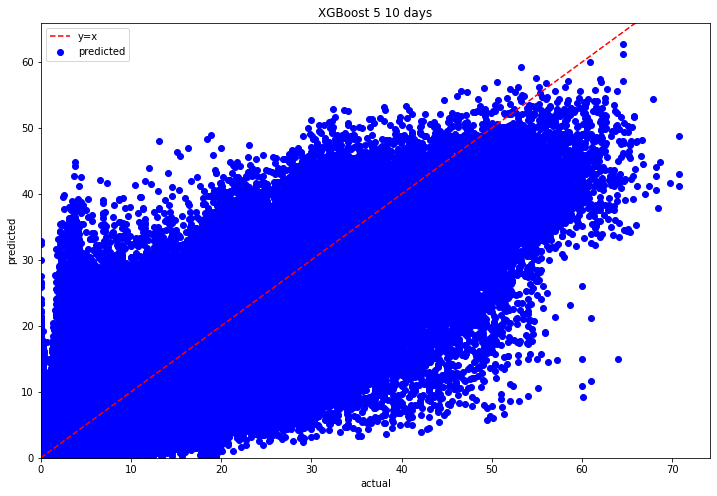

In [45]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 5 10 days')


In [47]:
performance_metrics(preds, y_test.values.reshape(-1))


MSE: 12.9097
RMSE: 3.5930
MAE: 1.7078
WMAPE: 41.8097
R2: 0.8244


##### From 5 to 9 days

XGBoost 9 days


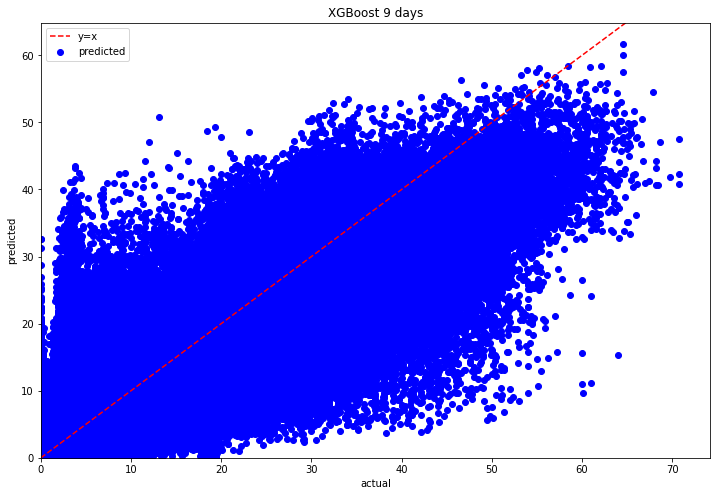

MSE: 13.0323
RMSE: 3.6100
MAE: 1.7128
WMAPE: 41.9321
R2: 0.8227
XGBoost 8 days


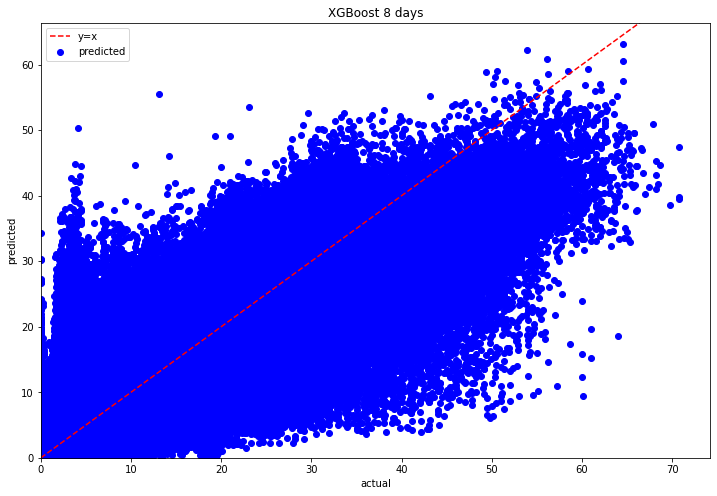

MSE: 13.9180
RMSE: 3.7307
MAE: 1.7911
WMAPE: 43.8476
R2: 0.8107
XGBoost 7 days


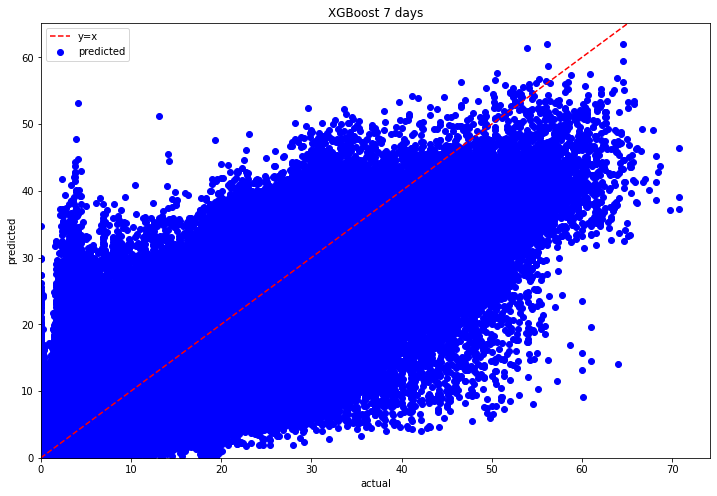

MSE: 14.0237
RMSE: 3.7448
MAE: 1.7954
WMAPE: 43.9548
R2: 0.8093
XGBoost 6 days


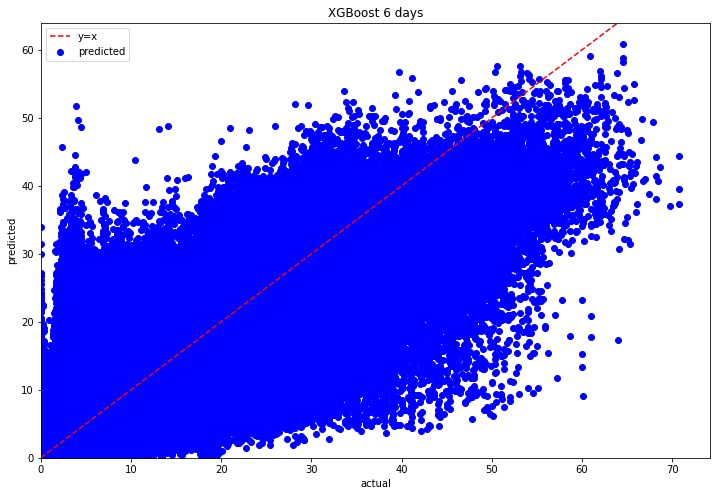

MSE: 14.0942
RMSE: 3.7542
MAE: 1.8007
WMAPE: 44.0840
R2: 0.8083
XGBoost 5 days


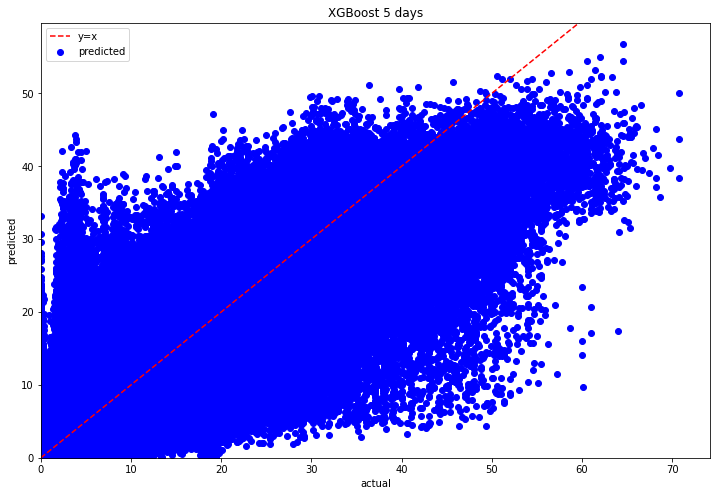

MSE: 14.2372
RMSE: 3.7732
MAE: 1.8037
WMAPE: 44.1561
R2: 0.8064


In [48]:
df5: pd.DataFrame = pd.read_pickle('df5.pkl')

for i in range(10, 5, -1):
    print(f"XGBoost {i - 1} days")

    not_cols = [f'energy_{j}' for j in range(i, 11)] + ['energy']
    # X_cols is all the columns except the energy
    X_cols = df5.columns.difference(not_cols)
    y_cols = ['energy']

    X_train, X_test, y_train, y_test = pre_processing(df5, X_cols, y_cols)

    # build the model
    _, preds = build_model(X_train, y_train, X_test)

    # plot the results
    plt.figure(figsize=(12, 8))

    plot_results(preds, y_test, f'XGBoost {i - 1} days')

    # performance metrics
    performance_metrics(preds, y_test.values.reshape(-1))

### Sixth Model

Do the best model without the weather data.

In [49]:
df4: pd.DataFrame = pd.read_pickle('df4.pkl')

rm_cols = ['temp', 'rhum', 'wspd', 'pres']
X_cols = df4.columns.difference(['energy'] + rm_cols)
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df4, X_cols, y_cols)


In [50]:
_, preds = build_model(X_train, y_train, X_test)


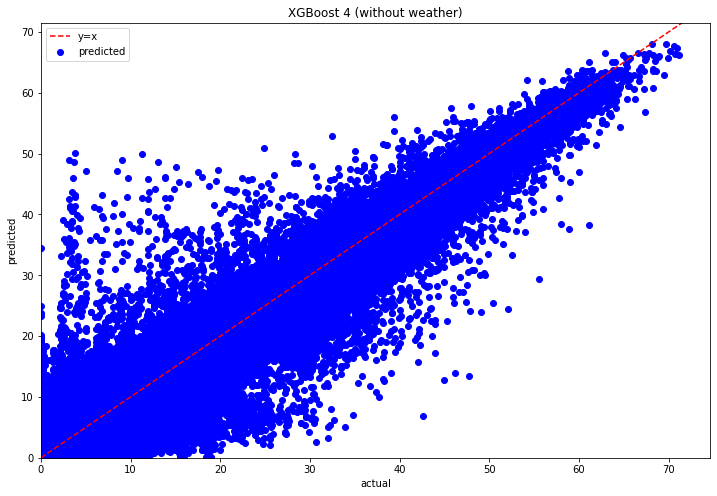

In [51]:
plt.figure(figsize=(12, 8))

plot_results(preds, y_test, 'XGBoost 4 (without weather)')

In [52]:
performance_metrics(preds, y_test.values.reshape(-1))


MSE: 1.7788
RMSE: 1.3337
MAE: 0.5054
WMAPE: 12.4213
R2: 0.9757


### Sixth Model

Use the best algorithm with XGBoost over different time windows.

In [3]:
df4: pd.DataFrame = pd.read_pickle('df4.pkl')
df4.head()


,energy,temp,rhum,wspd,pres,energy_1,energy_2,energy_3,energy_4,energy_5,...,energy_39,energy_40,energy_41,energy_42,energy_43,energy_44,energy_45,energy_46,energy_47,energy_48
78994,0.08,16.6,57.5,11.2,1010.70,0.08,0.08,0.08,0.08,0.08,...,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08,0.07,0.08
79002,0.08,17.6,52.0,11.2,1010.60,0.08,0.08,0.08,0.08,0.08,...,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08,0.07
79011,0.08,16.6,59.5,13.0,1010.45,0.08,0.08,0.08,0.08,0.08,...,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07,0.08
79028,0.08,15.6,65.0,12.1,1010.25,0.08,0.08,0.08,0.08,0.08,...,0.56,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07,0.07
79037,0.08,15.6,63.0,9.4,1010.20,0.08,0.08,0.08,0.08,0.08,...,0.91,0.56,0.38,0.44,0.07,0.07,0.08,0.08,0.08,0.07


In [7]:
timeframe = [1, 2, 10, 24, 36] # different time frames to train the model (in 30 minutes intervals)

In [8]:
models = []

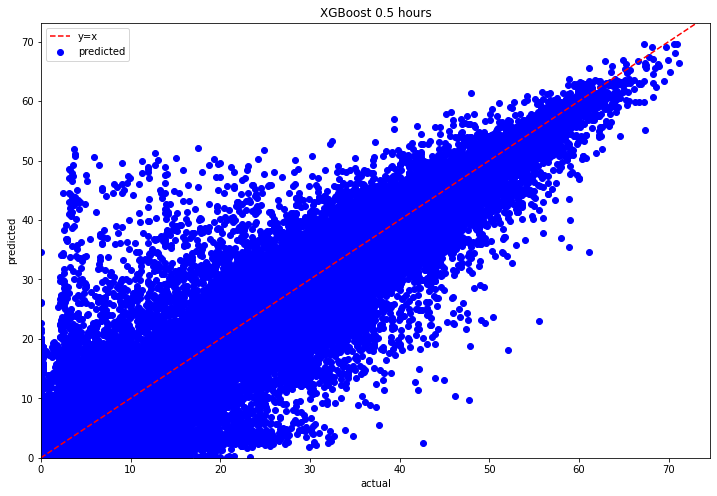

MSE: 2.3269
RMSE: 1.5254
MAE: 0.5273
WMAPE: 12.9595
R2: 0.9682


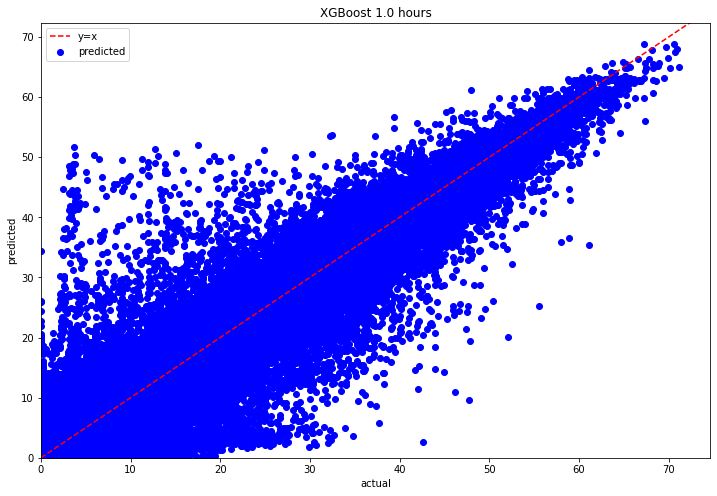

MSE: 2.1591
RMSE: 1.4694
MAE: 0.5132
WMAPE: 12.6131
R2: 0.9704


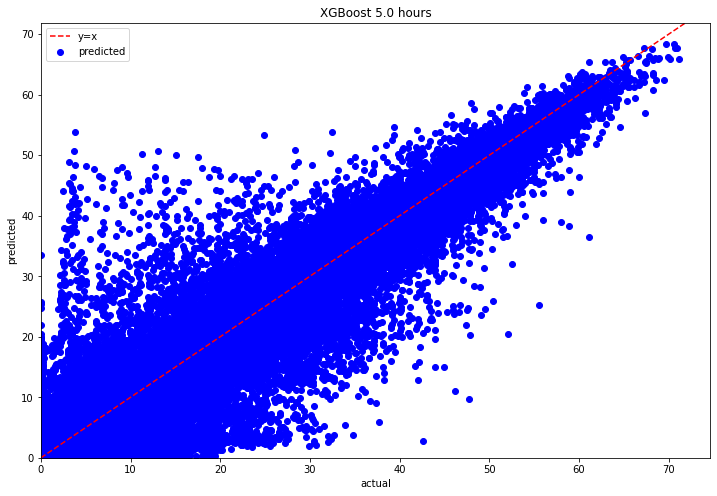

MSE: 2.0122
RMSE: 1.4185
MAE: 0.5060
WMAPE: 12.4349
R2: 0.9725


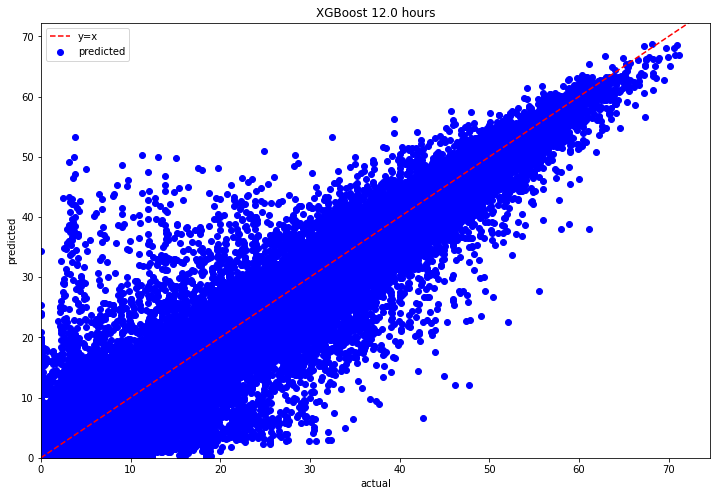

MSE: 1.8289
RMSE: 1.3524
MAE: 0.5080
WMAPE: 12.4845
R2: 0.9750


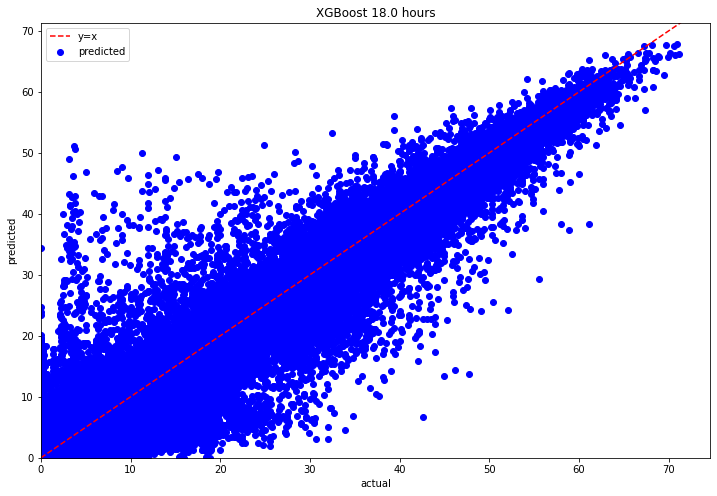

MSE: 1.7757
RMSE: 1.3325
MAE: 0.5049
WMAPE: 12.4076
R2: 0.9757


In [9]:
for t in timeframe:
    y_cols = ['energy']
    X_cols = df4.columns.difference(y_cols + [f'energy_{j}' for j in range(t + 1, 49)])

    X_train, X_test, y_train, y_test = pre_processing(df4, X_cols, y_cols)

    model, preds = build_model(X_train, y_train, X_test)
    models.append(model)

    plt.figure(figsize=(12, 8))

    plot_results(preds, y_test, f'XGBoost {t / 2} hours')

    performance_metrics(preds, y_test.values.reshape(-1))


In [13]:
models = dict(zip(timeframe, models))

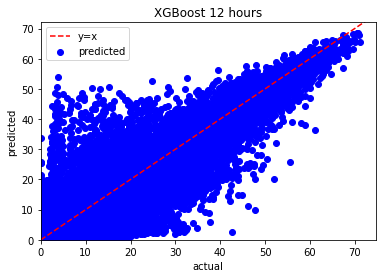

MSE: 1.9972
RMSE: 1.4132
MAE: 0.5060
WMAPE: 12.4345
R2: 0.9727


In [14]:
# do the same, but for 6 hours (12 / 2 hours)
X_cols = df4.columns.difference(['energy'] + [f'energy_{j}' for j in range(13, 49)])
y_cols = ['energy']

X_train, X_test, y_train, y_test = pre_processing(df4, X_cols, y_cols)

model, preds = build_model(X_train, y_train, X_test)

models[12] = model

plot_results(preds, y_test, 'XGBoost 12 hours')

performance_metrics(preds, y_test.values.reshape(-1))


In [15]:
# save models to pickle
import pickle

pickle.dump(models, open('models.pkl', 'wb'))